## Data Preparation
#### Helper Functions and Prep

In [10]:
import json
import os
import pandas as pd
import numpy as np
import concurrent.futures
from pathlib import Path
import re
import seaborn as sns

from openai import AzureOpenAI
import replicate
from anthropic import Anthropic
import time

import threading
import datetime

import matplotlib.pyplot as plt

In [ ]:
azure_key = "INSERT_KEY_HERE"
anthropic_key = "INSERT_KEY_HERE"
replicate_key = "INSERT_KEY_HERE"

In [ ]:
openai_client = AzureOpenAI(
        azure_endpoint = "INSERT_HERE", 
        api_key=YOUR_KEY,  
        api_version="2024-08-01-preview"
        )

model_gpt ="gpt-4o-2024-08-06"



clientAnthropic = Anthropic(
    api_key=anthropic_key
)



input = {
    "prompt": "Hi, what is the capital of France?",
}

replicateClient = replicate.Client(api_token=replicate_key)

#### Transform SALSA format to custom semi-complex format (flatten)

In [14]:
# # turn complex (SALSA, human-generated) format into semicomplex format for 1:1 comparison
from helper_functions import convert_complex_to_simple, SIGNIFICANCE_MAP
# import json


with open("../data/salsa_peer_annotations/final_peer_annotations/annotations_M_Gold.json", "r", encoding="utf-8") as f:
    complex_data = json.load(f)

simple_data = convert_complex_to_simple(complex_data)

simple_data


[{'source': 'Auch wenn ihn seine Arbeit als Apotheker davon abhielt, viel zu verreisen, unterhielt er ganze Reihe von Briefkontakten, unter anderem mit dem Züricher Botaniker Conrad Gessner und dem Nürnberger Arzt und Botaniker Joachim Camerarius dem Jüngeren.',
  'target': 'Auch wenn ihn seine Arbeit als Apotheker davon abhielt, viel zu verreisen, unterhielt er ganze Reihe von Briefkontakten mit den Jüngeren.',
  'metadata': {'annotator': 'annotator_0', 'system': 'MBART'},
  'edits': [{'category': 'deletion',
    'input_text': ['unter anderem'],
    'output_text': [],
    'quality': 'bad',
    'significance': 1},
   {'category': 'deletion',
    'input_text': ['dem Züricher Botaniker Conrad Gessner und dem Nürnberger Arzt und Botaniker Joachim Camerarius'],
    'output_text': [],
    'quality': 'bad',
    'significance': 1}],
  '_thresh_id': 1},
 {'source': 'Am 22. März 1985 unterzeichnete die Europäische Gemeinschaft gemeinsam mit mehreren Mitgliedstaaten das Wiener Übereinkommen zum 

#### Function Definitions

In [15]:
# ---------------------------------
# Global Significance Mapping
# ---------------------------------
SIGNIFICANCE_MAP = {
    "minor": 1,
    "medium": 2,
    "major": 3,
    "trivial": 0
}

# ---------------------------------
# 1. Data Loading Functions
# ---------------------------------
def load_json(file_path):
    """Load JSON data from a file."""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

# ---------------------------------
# 2. Loading the Prompt Template
# ---------------------------------
def load_prompt(prompt_file):
    """Load the judgment prompt template from a text file."""
    print(f"DEBUG: trying to load prompt from {prompt_file}")
    with open(prompt_file, 'r', encoding='utf-8') as f:
        template = f.read()
    return template

# ---------------------------------
# 3. Enhanced Prompt Builder
# ---------------------------------
def build_enhanced_prompt_from_template(template, source, simplified, annotations_A, annotations_B):
    """
    Build an enhanced prompt by inserting provided data into the template.
    
    The template should include the following tags:
        <source> ... </source>
        <simplified> ... </simplified>
        <annotations_A> ... </annotations_A>
        <annotations_B> ... </annotations_B>
    """
    def insert_text(template_text, tag, new_text):
        pattern = re.compile(rf"(?s)(<{tag}>).*?(</{tag}>)")
        return pattern.sub(rf"<{tag}>\n{new_text}\n</{tag}>", template_text)
    
    prompt = insert_text(template, "source", source)
    prompt = insert_text(prompt, "simplified", simplified)
    prompt = insert_text(prompt, "annotations_A", annotations_A)
    prompt = insert_text(prompt, "annotations_B", annotations_B)
    return prompt

# ---------------------------------
# Significance Helpers
# ---------------------------------
def invert_significance_map():
    """Return an inverse mapping: numeric value -> descriptive text."""
    return {v: k for k, v in SIGNIFICANCE_MAP.items()}

def format_edits(annotation):
    """
    Format the 'edits' section of an annotation dictionary into a readable string.
    """
    inv_map = invert_significance_map()
    edits = annotation.get("edits", [])
    if not edits:
        return "No edits provided."
    lines = []
    for i, edit in enumerate(edits, start=1):
        cat = edit.get("category", "N/A")
        quality = edit.get("quality", "N/A")
        # Convert the numeric significance into descriptive text.
        significance = edit.get("significance", "N/A")
        significance = inv_map.get(significance, f"unknown({significance})")
        input_text = ", ".join(edit.get("input_text", []))
        output_text = ", ".join(edit.get("output_text", []))
        lines.append(f"Edit {i}: Category: {cat}; Quality: {quality}; Significance: {significance}; Input: '{input_text}'; Output: '{output_text}'")
    return "\n".join(lines)

# ---------------------------------
# 4. Enhanced Merging Functions
# ---------------------------------
def find_matching_llm(human_item, llm_data, initial_length=10, step=10):
    """
    Find a matching LLM annotation for a given human annotation using a prefix-matching approach.
    """
    source = human_item.get('source', '')
    if not source:
        return None

    k = initial_length
    matched = None

    # Increase k until a unique match is found or we run out of characters.
    while k <= len(source):
        human_key = source[:k]
        candidates = [llm for llm in llm_data if llm.get('source', '').startswith(human_key)]
        if len(candidates) == 1:
            matched = candidates[0]
            break
        elif len(candidates) > 1:
            k += step
        else:
            break
    return matched


def merge_annotations(human_data, llm_data):
    """
    Merge human and LLM annotations by matching their _thresh_id values.
    
    """
    merged_data = []
    min_length = min(len(human_data), len(llm_data))

    if len(human_data) != len(llm_data):
        print(f"Warning: Unequal number of sentences. Human: {len(human_data)}, LLM: {len(llm_data)} -> using thresh_ID matching")
    
    # Create dictionaries with _thresh_id as key for faster lookup
    human_dict = {item.get('_thresh_id'): item for item in human_data}
    llm_dict = {item.get('_thresh_id'): item for item in llm_data}
    
    # Check if all IDs match
    human_ids = set(human_dict.keys())
    llm_ids = set(llm_dict.keys())
    
    if human_ids != llm_ids:
        print(f"Warning: Mismatch in _thresh_id values between datasets:")
        print(f"Human IDs: {len(human_ids)}; LLM IDs: {len(llm_ids)}")
        print(f"Matching only the common IDs...")
    
    # Match and merge annotations
    for thresh_id in sorted(llm_ids):
        merged_data.append({
            'example_id': thresh_id,
            'human_annotation': human_dict[thresh_id],
            'llm_annotation': llm_dict[thresh_id],
        })
    
    return pd.DataFrame(merged_data)

# ---------------------------------
# 5. LLM Judgment Function with Azure OpenAI and Filtering
# ---------------------------------
def call_llm(prompt, human_annotation, llm_annotation, model='gpt-4o-latest', human_first=True):
    """
    Call the Azure OpenAI API to judge which annotation is better.
    
    Depending on the human_first flag, either the human annotation is shown first or the LLM annotation.
    Returns a dictionary with:
        - 'final_answer': the parsed decision (e.g., "A" or "B")
        - 'raw_response': the full API response
        - 'showed_first': either "human" or "LLM"
        - 'model': the model string used.
    """
    source_text = human_annotation.get("source", "")
    simplified_text = human_annotation.get("target", "")
    
    # Determine the order of annotations.
    if human_first:
        annotations_A_text = format_edits(human_annotation)
        annotations_B_text = format_edits(llm_annotation)
        showed_first = "human"
    else:
        annotations_A_text = format_edits(llm_annotation)
        annotations_B_text = format_edits(human_annotation)
        showed_first = "LLM"
    
    # Build the enhanced prompt.
    enhanced_prompt = build_enhanced_prompt_from_template(
        template=prompt,
        source=source_text,
        simplified=simplified_text,
        annotations_A=annotations_A_text,
        annotations_B=annotations_B_text
    )


    # if the model string contains "deepkseek" or "llama", use replicate
    if "deepseek" in model or "llama" in model:
        print("    ...sent request to Replicate with enhanced prompt...")
        output = replicateClient.run(
            model,
            input= {
            "prompt": enhanced_prompt,
        }
        )
        raw_message = "".join(output)

    elif 'sonnet' in model: # use anthropic
        time.sleep(np.random.randint(0,30)) #wait a random time between 10 and 50 seconds to avoid rate limiting
        print("    ...sent request to Anthropic with enhanced prompt...")
        response = clientAnthropic.messages.create(
                max_tokens=8096,
                messages=[
                    {
                        "role": "user",
                        "content": enhanced_prompt
                    }
                ],
                model=model
                )
        raw_message = response.content[0].text
        
    
    # else if the model string contains "gpt", use Azure OpenAI
    else:
        time.sleep(np.random.randint(0,30)) #wait a random time between 10 and 50 seconds to avoid rate limiting
        print("    ...sent request to Azure OpenAI with enhanced prompt...")
        print(f" DEBUG: {enhanced_prompt}")
        response = openai_client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": enhanced_prompt}
            ]
        )
        
        print("    ...received response from Azure OpenAI...")
        raw_message = response.choices[0].message.content
    
    print(f"  Raw received message: {raw_message}")
    
    # Use regex to extract the final answer (expecting "Final Answer: A" or "Final Answer: B").
    match = re.search(r"final answer\s*[:\-]\s*([AB])", raw_message, flags=re.IGNORECASE)
    if match:
        final_answer = match.group(1).upper()
    else:
        final_answer = "unknown"
    print(f" -> extracted Final answer: {final_answer}")
    
    return {
        "final_answer": final_answer,
        "raw_response": raw_message,
        "showed_first": showed_first,
        "model": model
    }

# ---------------------------------
# 6. Parallel Execution for Pairwise Comparisons
# ---------------------------------
def run_pairwise_comparisons(df, prompt, parallel_calls=4, model='gpt-4o-latest', human_first=True):
    """
    Run pairwise LLM judgments on the merged annotations in parallel.
    
    Returns:
        pd.DataFrame: A DataFrame with columns:
            example_id, final_answer, raw_response, showed_first, model.
    """
    results = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=parallel_calls) as executor:
        future_to_index = {
            executor.submit(call_llm, prompt, row['human_annotation'], row['llm_annotation'], model, human_first): index 
            for index, row in df.iterrows()
        }
        for future in concurrent.futures.as_completed(future_to_index):
            index = future_to_index[future]
            try:
                decision_info = future.result()
            except Exception as e:
                decision_info = {
                    "final_answer": f"error: {e}",
                    "raw_response": None,
                    "showed_first": "error",
                    "model": model
                }
            result_entry = {
                "example_id": index,
                "final_answer": decision_info.get("final_answer"),
                "raw_response": decision_info.get("raw_response"),
                "showed_first": decision_info.get("showed_first"),
                "model": decision_info.get("model")
            }
            results.append(result_entry)
    return pd.DataFrame(results)

# ---------------------------------
# 7. Saving the Results (Optional)
# ---------------------------------
def save_results(results_df, output_file):
    """Save the results DataFrame to a CSV file."""
    results_df.to_csv(output_file, index=False)


# ---------------------------------
# 8. Pipeline Runner
# ---------------------------------
def run_pipeline_filePair(human_file, llm_file, prompt_file, output_file, 
    human_first=True, model='gpt-4o-latest', run_twice=True,
    run_only_firstRow=False
):
    # Load the data
    human_data = load_json(human_file)
    llm_data = load_json(llm_file)
    prompt = load_prompt(prompt_file)
    print("...loaded data...")
    print(f"DEBUG: human_file: {human_file}; llm_file: {llm_file}; prompt_file: {prompt_file}")

    # Transform complex to simple (assuming this function is defined)
    human_data = convert_complex_to_simple(human_data)
    print("...transformed human data...")
    
    # Merge the annotations
    merged_df = merge_annotations(human_data, llm_data)
    print("...merged data...")
    #display(merged_df)

    if run_only_firstRow:
        merged_df = merged_df.head(1)
        print("...DEBUG: only running first row...")
    
    # Run the pairwise comparisons with the desired display order and model.
    results_df = run_pairwise_comparisons(merged_df, prompt, parallel_calls=10, model=model, human_first=human_first)
    print("...ran pairwise comparisons...")
    print("Results DataFrame:")
    print(results_df)

    if run_twice:
        # Run the pairwise comparisons with the opposite display order.
        results_df_2 = run_pairwise_comparisons(merged_df, prompt, parallel_calls=10, model=model, human_first=not human_first)
        print("...ran pairwise comparisons (second run)...")
        #display(results_df_2)
        print("Results DataFrame (second run):")
        print(results_df_2)
        results_df = pd.concat([results_df, results_df_2], ignore_index=True)
        print("Combined Results DataFrame:")
        print(results_df)
    
    return results_df

In [16]:
# ---------------------------------
# 10. Running Multiple Models and Multiple Prompts Concurrently
# ---------------------------------
def run_multiple_models_parallel(human_file, llm_file, prompt_files, output_file_prefix, models, 
                                               human_first=True, run_twice=True, run_only_firstRow=False, max_workers=None):
    """
    Run the pipeline concurrently for multiple models and multiple prompt files.
    
    For each prompt file in prompt_files and for each model in models, the pipeline is run.
    The resulting DataFrame from each run is tagged with the prompt file (or a derived label) and the model used.
    All results are concatenated into one big DataFrame.
    
    
    Returns:
        pd.DataFrame: A DataFrame with concatenated results from all prompt and model combinations.
    """
    all_results = []
    futures = []
    
    # If max_workers is not set, use the product of the number of prompt files and models.
    if max_workers is None:
        max_workers = len(prompt_files) * len(models)
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        for prompt_file in prompt_files:
            for model in models:
                print(f"\nSubmitting pipeline for prompt: {prompt_file} and model: {model}")
                output_file = f"{output_file_prefix}_{model}_{Path(prompt_file).stem}.csv"
                future = executor.submit(
                    run_pipeline_filePair,
                    human_file,
                    llm_file,
                    prompt_file,
                    output_file,
                    human_first,
                    model,
                    run_twice,
                    run_only_firstRow
                )
                futures.append((prompt_file, model, future))
        
        for prompt_file, model, future in futures:
            try:
                df = future.result()
                # Tag the results with the prompt file name.
                df['prompt_file'] = Path(prompt_file).name
                all_results.append(df)
            except Exception as exc:
                print(f"Combination (prompt: {prompt_file}, model: {model}) generated an exception: {exc}")
    
    combined_df = pd.concat(all_results, ignore_index=True)
    combined_output_file = f"{output_file_prefix}_combined.csv"
    combined_df.to_csv(combined_output_file, index=False)
    print(f"\nCombined results saved to {combined_output_file}")
    return combined_df



def run_multiple_models_sequential(human_file, llm_file, prompt_files, output_file_prefix, models,
                                 human_first=True, run_twice=True, run_only_firstRow=False):
    """
    Run the pipeline sequentially for multiple models and multiple prompt files.
    """
    all_results = []
    
    for prompt_file in prompt_files:
        for model in models:
            print(f"\nRunning pipeline for prompt: {prompt_file} and model: {model}")
            output_file = f"{output_file_prefix}_{model}_{Path(prompt_file).stem}.csv"
            
            try:
                df = run_pipeline_filePair(
                    human_file,
                    llm_file,
                    prompt_file,
                    output_file,
                    human_first,
                    model,
                    run_twice,
                    run_only_firstRow
                )
                # Tag the results with the prompt file name
                df['prompt_file'] = Path(prompt_file).name
                all_results.append(df)
                print(f"Completed processing for prompt: {prompt_file} and model: {model}")
            except Exception as exc:
                print(f"Combination (prompt: {prompt_file}, model: {model}) generated an exception: {exc}")
    
    combined_df = pd.concat(all_results, ignore_index=True)
    combined_output_file = f"{output_file_prefix}_combined.csv"
    combined_df.to_csv(combined_output_file, index=False)
    print(f"\nCombined results saved to {combined_output_file}")
    return combined_df

In [ ]:
from helper_functions import get_api_type

# ---------------------------------
# Create a global dictionary with one lock per API
# ---------------------------------
API_LOCKS = {
    "azure": threading.Lock(),
    "anthropic": threading.Lock(),
    "replicate": threading.Lock(),
}


def call_llm(prompt, human_annotation, llm_annotation, model='gpt-4o-latest', human_first=True):
    """
    Call the appropriate API (Azure, Anthropic, or Replicate) while ensuring that for each API
    only one call is sent out at a time. This is done via per-API locks.
    
    Depending on human_first, we set the order of annotations.
    """
    source_text = human_annotation.get("source", "")
    simplified_text = human_annotation.get("target", "")
    
    # Determine the order of annotations.
    if human_first:
        annotations_A_text = format_edits(human_annotation)
        annotations_B_text = format_edits(llm_annotation)
        showed_first = "human"
    else:
        annotations_A_text = format_edits(llm_annotation)
        annotations_B_text = format_edits(human_annotation)
        showed_first = "LLM"
    
    # Build the enhanced prompt.
    enhanced_prompt = build_enhanced_prompt_from_template(
        template=prompt,
        source=source_text,
        simplified=simplified_text,
        annotations_A=annotations_A_text,
        annotations_B=annotations_B_text
    )
    
    # Determine which API to use based on the model string.
    api_type = get_api_type(model)
    
    if api_type in ("azure", "anthropic"):
        time.sleep(np.random.randint(0, 30))
    
    # Ensure that only one call is sent out per API at a time.
    with API_LOCKS[api_type]:
        if api_type == "replicate":
            print("    ...sent request to Replicate with enhanced prompt...")
            output = replicateClient.run(
                model,
                input={"prompt": enhanced_prompt}
            )
            raw_message = "".join(output)
    
        elif api_type == "anthropic":
            print("    ...sent request to Anthropic with enhanced prompt...")
            response = clientAnthropic.messages.create(
                max_tokens=8096,
                messages=[
                    {"role": "user", "content": enhanced_prompt}
                ],
                model=model
            )
            raw_message = response.content[0].text
            
        elif api_type == "azure":
            print("    ...sent request to Azure OpenAI with enhanced prompt...")
            print(f" DEBUG: {enhanced_prompt}")
            response = openai_client.chat.completions.create(
                model=model,  # Use the appropriate deployment/model.
                messages=[
                    {"role": "system", "content": "You are a helpful assistant."},
                    {"role": "user", "content": enhanced_prompt}
                ]
            )
            print("    ...received response from Azure OpenAI...")
            raw_message = response.choices[0].message.content
        else:
            raw_message = "Error: Unrecognized API type"
    
    print(f"  Raw received message: {raw_message}")
    
    # Extract the final answer (e.g., "Final Answer: A" or "Final Answer: B")
    match = re.search(r"final answer\s*[:\-]\s*([AB])", raw_message, flags=re.IGNORECASE)
    if match:
        final_answer = match.group(1).upper()
    else:
        final_answer = "unknown"
    print(f" -> extracted Final answer: {final_answer}")
    
    return {
        "final_answer": final_answer,
        "raw_response": raw_message,
        "showed_first": showed_first,
        "model": model
    }

### Function Def. - Analysis

In [18]:
def quick_inspection(df):
    print(df.model.value_counts())
    print(df.prompt_file.value_counts())
    print(df.showed_first.value_counts())

    if "ShotMode" in df.columns:
        print(df.ShotMode.value_counts())

    if "AnnoModel" in df.columns:
        print(df.AnnoModel.value_counts())

    display(df.head())

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.formula.api as smf
import seaborn as sns

def run_preferenceRanking_analysis(df, statistical_deepdive=False):
    # Remove rows where final_answer is not A or B
    df_f = df[df['final_answer'].isin(['A', 'B'])].copy()

    print("Final answer counts:")
    print(df_f['final_answer'].value_counts())

    # Create the winner column:
    df_f['winner'] = np.where(
        ((df_f['showed_first'] == 'human') & (df_f['final_answer'] == 'A')) |
        ((df_f['showed_first'] == 'LLM') & (df_f['final_answer'] == 'B')),
        'human', 
        'LLM'
    )

    print("Sample of processed data:")
    print(df_f[['showed_first', 'final_answer', 'winner']].head())

    # --------------------------
    # Plot 1: Winner counts
    # --------------------------
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df_f, x='winner')
    plt.title("Winner Counts")
    plt.xlabel("Winner")
    plt.ylabel("Count")
    plt.show()  # Display the first plot

    # --------------------------
    # Plot: Comparison by prompt_file
    # --------------------------
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df_f, x='prompt_file', hue='winner')
    plt.title("Winner by Prompt File")
    plt.xlabel("Prompt File")
    plt.ylabel("Count")
    plt.show()  # Display the second plot

    # --------------------------
    # Plot: Comparison by prompt mode (few shot vs zero shot)
    # --------------------------
    if "ShotMode" in df_f.columns:
        plt.figure(figsize=(8, 6))
        sns.countplot(data=df_f, x='ShotMode', hue='winner')
        plt.title("Winner by Zero vs Few Shot")
        plt.xlabel("Shot Mode")
        plt.ylabel("Count")
        plt.show()  # Display the second plot
    # --------------------------
    # Plot: Comparison by Judge model
    # --------------------------
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=df_f, x='model', hue='winner')
    plt.title("Winner by Judge Model")
    plt.xlabel("Judge Model")
    plt.ylabel("Count")
    plt.xticks(rotation=90)
    plt.show()  # Display the third plot

    # --------------------------
    # Plot: Comparison by Annotator Model
    # --------------------------
    if "AnnoModel" in df_f.columns:
        plt.figure(figsize=(10, 6))
        ax = sns.countplot(data=df_f, x='AnnoModel', hue='winner')
        plt.title("Winner by Annotator Model")
        plt.xlabel("Annotator Model")
        plt.ylabel("Count")
        plt.xticks(rotation=90)
        plt.show()

    # Optionally, print percentage counts.
    print("Winner counts (percentage):")
    print(df_f['winner'].value_counts(normalize=True).mul(100).round(2))

    print("Winner by Prompt File (percentage):")
    print(df_f.groupby('prompt_file')['winner'].value_counts(normalize=True).mul(100).round(2))

    if "ShotMode" in df_f.columns:
        print("Winner by Shot Mode (percentage):")
        print(df_f.groupby('ShotMode')['winner'].value_counts(normalize=True).mul(100).round(2))

    print("Winner by Judge Model (percentage):")
    print(df_f.groupby('model')['winner'].value_counts(normalize=True).mul(100).round(2))

    if "AnnoModel" in df_f.columns:
        print("Winner by Annotator Model (percentage):")
        print(df_f.groupby('AnnoModel')['winner'].value_counts(normalize=True).mul(100).round(2))


     # --------------------------
    # Overall Proportions Z-test
    # --------------------------
    human_wins = (df_f['winner'] == 'human').sum()
    total_trials = len(df_f)
    
    stat, pval = proportions_ztest(count=human_wins, nobs=total_trials, value=0.5)
    
    print("\nOverall Proportions Z-test (H0: human win rate = 0.5):")
    print(f"  Total Trials: {total_trials}")
    print(f"  Human wins: {human_wins}")
    print(f"  Z-statistic: {stat:.3f}")
    print(f"  p-value: {pval:.3f}")
    if pval < 0.05:
        print("  Result: Statistically significant difference from a 50/50 win rate.")
    else:
        print("  Result: No statistically significant difference from a 50/50 win rate.")

    if statistical_deepdive:
        # --------------------------
        # Deep Dive: Proportion Tests by Prompt File
        # --------------------------
        print("\nDeep Dive: Analysis by Prompt File")
        for prompt in df_f['prompt_file'].unique():
            df_prompt = df_f[df_f['prompt_file'] == prompt]
            human_wins_prompt = (df_prompt['winner'] == 'human').sum()
            total_prompt = len(df_prompt)
            stat_prompt, pval_prompt = proportions_ztest(count=human_wins_prompt, nobs=total_prompt, value=0.5)
            print(f"\nPrompt File: {prompt}")
            print(f"  Total Trials: {total_prompt}")
            print(f"  Human wins: {human_wins_prompt}")
            print(f"  Z-statistic: {stat_prompt:.3f}")
            print(f"  p-value: {pval_prompt:.3f}")
            if pval_prompt < 0.05:
                print("  Result: Statistically significant difference from a 50/50 win rate.")
            else:
                print("  Result: No statistically significant difference from a 50/50 win rate.")

        # --------------------------
        # Deep Dive: Proportion Tests by Shot Mode
        # --------------------------
        if "ShotMode" in df_f.columns:
            print("\nDeep Dive: Analysis by Shot Mode")
            for mode in df_f['ShotMode'].unique():
                df_mode = df_f[df_f['ShotMode'] == mode]
                human_wins_mode = (df_mode['winner'] == 'human').sum()
                total_mode = len(df_mode)
                stat_mode, pval_mode = proportions_ztest(count=human_wins_mode, nobs=total_mode, value=0.5)
                print(f"\nShot Mode: {mode}")
                print(f"  Total Trials: {total_mode}")
                print(f"  Human wins: {human_wins_mode}")
                print(f"  Z-statistic: {stat_mode:.3f}")
                print(f"  p-value: {pval_mode:.3f}")
                if pval_mode < 0.05:
                    print("  Result: Statistically significant difference from a 50/50 win rate.")
                else:
                    print("  Result: No statistically significant difference from a 50/50 win rate.")

        # --------------------------
        # Deep Dive: Proportion Tests by JUDGE Model
        # --------------------------
        print("\nDeep Dive: Analysis by Model")
        for mdl in df_f['model'].unique():
            df_model = df_f[df_f['model'] == mdl]
            human_wins_model = (df_model['winner'] == 'human').sum()
            total_model = len(df_model)
            stat_model, pval_model = proportions_ztest(count=human_wins_model, nobs=total_model, value=0.5)
            print(f"\nModel: {mdl}")
            print(f"  Total Trials: {total_model}")
            print(f"  Human wins: {human_wins_model}")
            print(f"  Z-statistic: {stat_model:.3f}")
            print(f"  p-value: {pval_model:.3f}")
            if pval_model < 0.05:
                print("  Result: Statistically significant difference from a 50/50 win rate.")
            else:
                print("  Result: No statistically significant difference from a 50/50 win rate.")

        # --------------------------
        # Deep Dive: Proportion Tests by ANNOTATOR Model
        # --------------------------
        if "AnnoModel" in df_f.columns:
            print("\nDeep Dive: Analysis by Annotator Model")
            for anno in df_f['AnnoModel'].unique():
                df_anno = df_f[df_f['AnnoModel'] == anno]
                human_wins_anno = (df_anno['winner'] == 'human').sum()
                total_anno = len(df_anno)
                stat_anno, pval_anno = proportions_ztest(count=human_wins_anno, nobs=total_anno, value=0.5)
                print(f"\nAnnotator Model: {anno}")
                print(f"  Total Trials: {total_anno}")
                print(f"  Human wins: {human_wins_anno}")
                print(f"  Z-statistic: {stat_anno:.3f}")
                print(f"  p-value: {pval_anno:.3f}")
                if pval_anno < 0.05:
                    print("  Result: Statistically significant difference from a 50/50 win rate.")
                else:
                    print("  Result: No statistically significant difference from a 50/50 win rate.")

        # --------------------------
        # Alternative Approach: Logistic Regression
        # --------------------------
        # Create a binary outcome: 1 if human wins, 0 otherwise.
        df_f['win_binary'] = np.where(df_f['winner'] == 'human', 1, 0)
        
        # Fit a logistic regression model with model and prompt_file as categorical predictors.
        # This method tests the association of these factors with the likelihood of a human win.
        logit_formula = 'win_binary ~ C(model) + C(prompt_file)'
        logit_model = smf.logit(formula=logit_formula, data=df_f).fit(disp=0)
        
        print("\nLogistic Regression Results (win probability ~ model + prompt_file):")
        print(logit_model.summary())

In [20]:
# Specific Sub-Analysis: Winner by Shot Mode and Prompt File

def analyze_shot_mode_prompt_interaction(df):

    df_f = df[df['final_answer'].isin(['A', 'B'])].copy()

    print("Final answer counts:")
    print(df_f['final_answer'].value_counts())

    # Create the winner column:
    df_f['winner'] = np.where(
        ((df_f['showed_first'] == 'human') & (df_f['final_answer'] == 'A')) |
        ((df_f['showed_first'] == 'LLM') & (df_f['final_answer'] == 'B')),
        'human', 
        'LLM'
    )

    # Create a contingency table
    contingency = pd.crosstab(
        [df_f['ShotMode'], df_f['prompt_file']], 
        df_f['winner']
    ).reset_index()
    
    # Create a more readable version for visualization
    contingency['group'] = contingency['ShotMode'] + ' - ' + contingency['prompt_file']
    
    # Perform chi-square test
    from scipy.stats import chi2_contingency
    chi2, p_value, dof, expected = chi2_contingency(
        pd.crosstab(
            [df_f['ShotMode'], df_f['prompt_file']], 
            df_f['winner']
        )
    )
    
    # Calculate percentages for each group
    contingency['total'] = contingency['human'] + contingency['LLM']
    contingency['human_pct'] = (contingency['human'] / contingency['total'] * 100).round(2)
    contingency['llm_pct'] = (contingency['LLM'] / contingency['total'] * 100).round(2)
    
    # Visualization
    plt.figure(figsize=(12, 6))
    
    # Create grouped bar plot
    x = np.arange(len(contingency['group']))
    width = 0.35
    
    plt.bar(x - width/2, contingency['human_pct'], width, label='Human', color='skyblue')
    plt.bar(x + width/2, contingency['llm_pct'], width, label='LLM', color='lightcoral')
    
    plt.xlabel('Groups')
    plt.ylabel('Percentage')
    plt.title('Winner Distribution by Shot Mode and Prompt Type')
    plt.xticks(x, contingency['group'], rotation=45, ha='right')
    plt.legend()
    
    # Add percentage labels on bars
    for i in range(len(x)):
        plt.text(i - width/2, contingency['human_pct'][i], f"{contingency['human_pct'][i]}%", 
                ha='center', va='bottom')
        plt.text(i + width/2, contingency['llm_pct'][i], f"{contingency['llm_pct'][i]}%", 
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistical results
    print("\nContingency Table:")
    print(pd.crosstab([df_f['ShotMode'], df_f['prompt_file']], df_f['winner']))
    
    print(f"\nChi-square test results:")
    print(f"Chi-square statistic: {chi2:.2f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Degrees of freedom: {dof}")
    
    if p_value < 0.05:
        print("\nThe difference between groups is statistically significant (p < 0.05)")
    else:
        print("\nThere is no statistically significant difference between groups (p >= 0.05)")
    
    # Post-hoc analysis: pairwise chi-square tests if main test is significant
    if p_value < 0.05:
        print("\nPost-hoc pairwise comparisons:")
        groups = contingency['group'].unique()
        for i in range(len(groups)):
            for j in range(i+1, len(groups)):
                g1 = groups[i]
                g2 = groups[j]
                
                # Create 2x2 contingency table for this pair
                g1_data = contingency[contingency['group'] == g1]
                g2_data = contingency[contingency['group'] == g2]
                pair_contingency = pd.DataFrame({
                    'human': [g1_data['human'].iloc[0], g2_data['human'].iloc[0]],
                    'LLM': [g1_data['LLM'].iloc[0], g2_data['LLM'].iloc[0]]
                })
                
                chi2, p_value, _, _ = chi2_contingency(pair_contingency)
                print(f"\n{g1} vs {g2}:")
                print(f"Chi-square: {chi2:.2f}")
                print(f"p-value: {p_value:.4f}")

## Execute Ranking per API - once

In [50]:
# run_pipeline_filePair(human_file, llm_file, prompt_file, output_file)

## Execute Ranking per API - for multiple models
### Peer Set

In [ ]:
# Configuration: File paths and parallel settings
human_file = "../data/salsa_peer_annotations/final_peer_annotations/annotations_M_Gold.json"
llm_file = "../data/LLM_annotations/LLM_annotations_PeerSet_Heineman_ZeroShot_LLAMA8b_FULL.json"

prompt_files = [
        "prompts_LLM_annotations/pairwiseRanking_prompt.txt",
        "prompts_LLM_annotations/pairwiseRanking_prompt_detailled.txt"
    ]
    
output_file = "pairwise_results.csv"
parallel_calls = 10  # adjust this as needed

In [23]:
# LLM Files in Directory

directory_path = "../data/LLM_annotations"

llm_files = os.listdir(directory_path)

# those containing "PeerSet" are the ones we want to use
llm_files = [file for file in llm_files if "PeerSet" in file]

llm_files = [os.path.join(directory_path, file) for file in llm_files]

llm_files

['../data/LLM_annotations/LLM_annotations_PeerSet_Heineman_FewShot_LLAMA70b_FULL.json',
 '../data/LLM_annotations/LLM_annotations_PeerSet_Heineman_FewShot_ClaudeSonnet_FULL.json',
 '../data/LLM_annotations/LLM_annotations_PeerSet_Heineman_ZeroShot_LLAMA70b_FULL.json',
 '../data/LLM_annotations/LLM_annotations_PeerSet_Heineman_ZeroShot_ClaudeSonnet_FULL.json',
 '../data/LLM_annotations/LLM_annotations_PeerSet_Heineman_FewShot_LLAMA8b_FULL.json',
 '../data/LLM_annotations/LLM_annotations_PeerSet_Heineman_ZeroShot_O1Prev_FULL.json',
 '../data/LLM_annotations/LLM_annotations_PeerSet_Heineman_FewShot_GPT4o_FULL.json',
 '../data/LLM_annotations/LLM_annotations_PeerSet_Heineman_ZeroShot_LLAMA8b_FULL.json',
 '../data/LLM_annotations/LLM_annotations_PeerSet_Heineman_ZeroShot_DeepSeekR1_FULL.json',
 '../data/LLM_annotations/LLM_annotations_PeerSet_Heineman_ZeroShot_GPT4omini_FULL.json',
 '../data/LLM_annotations/LLM_annotations_PeerSet_Heineman_FewShot_o1Prev_FULL.json',
 '../data/LLM_annotation

In [24]:
for file in llm_files:
    # extract string between "Heineman" and "_FULL"
    model = re.search(r"Heineman_(.*?)_FULL", file).group(1)
    print(f"Model: {model}")

Model: FewShot_LLAMA70b
Model: FewShot_ClaudeSonnet
Model: ZeroShot_LLAMA70b
Model: ZeroShot_ClaudeSonnet
Model: FewShot_LLAMA8b
Model: ZeroShot_O1Prev
Model: FewShot_GPT4o
Model: ZeroShot_LLAMA8b
Model: ZeroShot_DeepSeekR1
Model: ZeroShot_GPT4omini
Model: FewShot_o1Prev
Model: ZeroShot_GPT4o
Model: FewShot_DeepSeekR1
Model: FewShot_GPT4omini


In [54]:
# Execute it for multiple judge models
models = [
    "gpt-4o-latest", 
    "o1-preview",
    "claude-3-5-sonnet-20241022",
    #"deepseek-ai/deepseek-r1",
    "meta/meta-llama-3-70b-instruct"
]

def run_multiple_models(human_file, llm_file, prompt_file, output_file_prefix, models, human_first=True,
        run_twice=True,
        run_only_firstRow=False
):
    """
    Run the pipeline for multiple models and return a combined DataFrame with all results.
    Returns:
        pd.DataFrame: A DataFrame with the concatenated results for all models.
    """
    all_results = []
    
    for model in models:
        print(f"\nRunning pipeline for model: {model}")
        # Create an output file name for the individual model results.
        output_file = f"{output_file_prefix}_{model}.csv"
        
        # Run the pipeline for this model.
        results_df = run_pipeline_filePair(
            human_file=human_file,
            llm_file=llm_file,
            prompt_file=prompt_file,
            output_file=output_file,
            human_first=human_first,
            model=model,
            run_twice=run_twice,
            run_only_firstRow=run_only_firstRow
        )
        
        # Append the results DataFrame to our list.
        all_results.append(results_df)
    
    # Concatenate all the individual DataFrames into one.
    combined_df = pd.concat(all_results, ignore_index=True)
    
    # Optionally save the combined results.
    combined_output_file = f"{output_file_prefix}_combined.csv"
    combined_df.to_csv(combined_output_file, index=False)
    print(f"\nCombined results saved to {combined_output_file}")
    
    return combined_df

### Large Dataset (n=50)
(using the taxonomy validation dataset)

In [25]:
prompt_files = [
        "prompts_LLM_annotations/pairwiseRanking_prompt.txt",
        "prompts_LLM_annotations/pairwiseRanking_prompt_detailled.txt"
    ]


# remove deepseek from this (due to cost reasons)
models = [
    "gpt-4o-latest", 
    #"gpt-4o-mini"
    "o1-preview",
    "claude-3-5-sonnet-20241022",
    #"deepseek-ai/deepseek-r1",
    "meta/meta-llama-3-70b-instruct"
]

models

['gpt-4o-latest',
 'o1-preview',
 'claude-3-5-sonnet-20241022',
 'meta/meta-llama-3-70b-instruct']

#### GPT-4o's Annotations

In [27]:
# Configuration: File paths and parallel settings
human_file = "../data/salsa_annotations/final_annotated/data_f_taxonomy_validation_subset_n50_MB.json"
llm_file = "../data/LLM_annotations/LLM_annotations_N50_Heineman_GPT4o_FULL.json"
modelName = "GPT4o"

now = datetime.datetime.now()
output_file_prefix = "../data/LLM-as-a-judge_outputs/results_TaxValSet50_" + modelName+ "_" + now.strftime("%Y-%m-%d_%H-%M-%S")

# Run the pipeline concurrently for all models -> n=50 validation set
# combined_results = run_multiple_models_parallel(
#     human_file, 
#     llm_file, 
#     prompt_files, 
#     output_file_prefix, 
#     models, 
#     human_first=True,
#     run_twice=True,
#     run_only_firstRow=False # only for debugging
# )

# Display the combined results.
# display(combined_results)

#### Claude Sonnet's Annotations

In [28]:
# Configuration: File paths and parallel settings
human_file = "../data/salsa_annotations/final_annotated/data_f_taxonomy_validation_subset_n50_MB.json"
llm_file = "../data/LLM_annotations/LLM_annotations_N50_Heineman_ClaudeSonnet_FULL.json"
modelName = "ClaudeSonnet"


output_file_prefix = "../data/LLM-as-a-judge_outputs/results_TaxValSet50_" + modelName+ "_" + now.strftime("%Y-%m-%d_%H-%M-%S")

models = [
    "gpt-4o-latest", 
    #"gpt-4o-mini"
    "o1-preview",
    "claude-3-5-sonnet-20241022",
    #"deepseek-ai/deepseek-r1",
    "meta/meta-llama-3-70b-instruct"
]

# Run the pipeline concurrently for all models -> n=50 validation set
# combined_results = run_multiple_models_parallel(
#     human_file, 
#     llm_file, 
#     prompt_files, 
#     output_file_prefix, 
#     models, 
#     human_first=True,
#     run_twice=True,
#     run_only_firstRow=False # only for debugging
# )

# Display the combined results.
# display(combined_results)

#### LLAMA 8bn's Annotations

In [29]:
# Configuration: File paths and parallel settings
human_file = "../data/salsa_annotations/final_annotated/data_f_taxonomy_validation_subset_n50_MB.json"
llm_file = "../data/LLM_annotations/LLM_annotations_N50_Heineman_LLAMA8b_FULL.json"
modelName = "LLAMA8bn"

output_file_prefix = "../data/LLM-as-a-judge_outputs/results_TaxValSet50_" + modelName+ "_" + now.strftime("%Y-%m-%d_%H-%M-%S")

# fix connection issue
models = [
    "gpt-4o-latest", 
    #"gpt-4o-mini"
    "o1-preview",
    "claude-3-5-sonnet-20241022",
    #"deepseek-ai/deepseek-r1",
    "meta/meta-llama-3-70b-instruct"
]

# # Run the pipeline concurrently for all models -> n=50 validation set
# combined_results = run_multiple_models_parallel(
#     human_file, 
#     llm_file, 
#     prompt_files, 
#     output_file_prefix, 
#     models, 
#     human_first=True,
#     run_twice=True,
#     run_only_firstRow=False # only for debugging
# )

# # Display the combined results.
# display(combined_results)

## Load complete dataframes
### Peer Dataset Analysis

In [32]:
filename = "../data/LLM-as-a-judge_outputs/results_f_peerSet_combined.csv"

df = pd.read_csv(filename)

quick_inspection(df)

model
gpt-4o-latest                     560
o1-preview                        560
claude-3-5-sonnet-20241022        560
meta/meta-llama-3-70b-instruct    560
Name: count, dtype: int64
prompt_file
pairwiseRanking_prompt.txt              1120
pairwiseRanking_prompt_detailled.txt    1120
Name: count, dtype: int64
showed_first
human    1120
LLM      1120
Name: count, dtype: int64
ShotMode
FewShot     1120
ZeroShot    1120
Name: count, dtype: int64
AnnoModel
LLAMA70b        320
DeepSeekR1      320
GPT4o           320
LLAMA8b         320
o1Prev          320
ClaudeSonnet    320
GPT4omini       320
Name: count, dtype: int64


,example_id,final_answer,raw_response,showed_first,model,prompt_file,ShotMode,AnnoModel
0,3,B,To evaluate the annotations provided by Annota...,human,gpt-4o-latest,pairwiseRanking_prompt.txt,FewShot,LLAMA70b
1,9,B,Let's analyze the annotations from Annotator A...,human,gpt-4o-latest,pairwiseRanking_prompt.txt,FewShot,LLAMA70b
2,5,A,To determine which set of annotations better r...,human,gpt-4o-latest,pairwiseRanking_prompt.txt,FewShot,LLAMA70b
3,1,B,Let's analyze the annotation sets from Annotat...,human,gpt-4o-latest,pairwiseRanking_prompt.txt,FewShot,LLAMA70b
4,2,B,To determine which annotation set better refle...,human,gpt-4o-latest,pairwiseRanking_prompt.txt,FewShot,LLAMA70b


Final answer counts:
final_answer
A    1226
B     989
Name: count, dtype: int64
Sample of processed data:
  showed_first final_answer winner
0        human            B    LLM
1        human            B    LLM
2        human            A  human
3        human            B    LLM
4        human            B    LLM


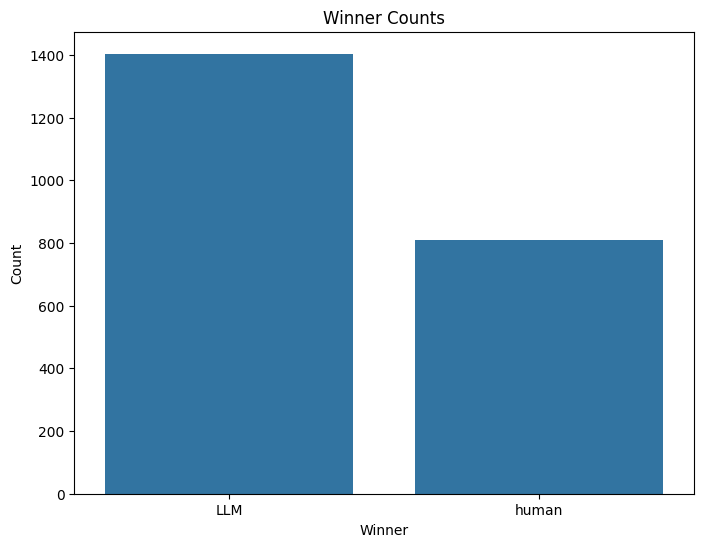

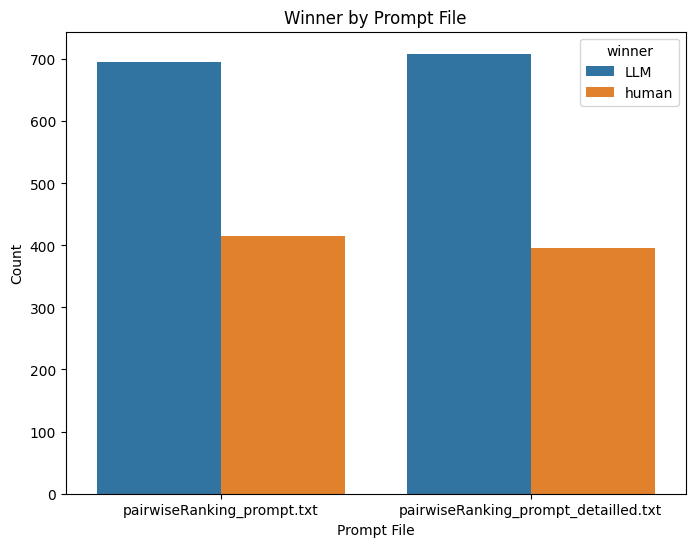

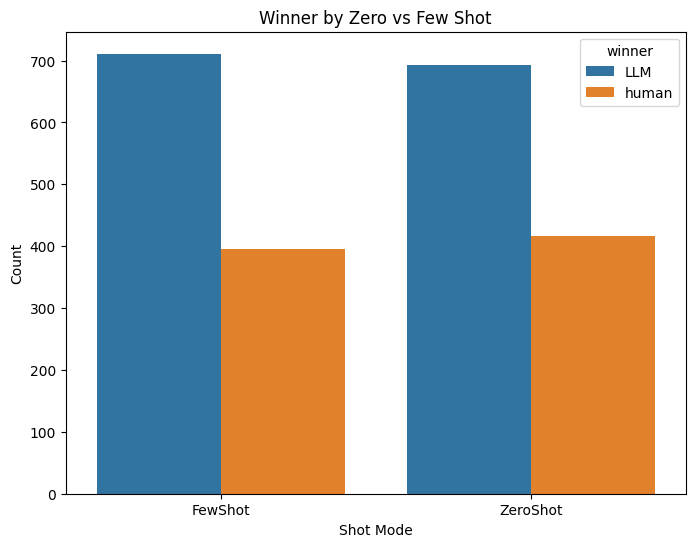

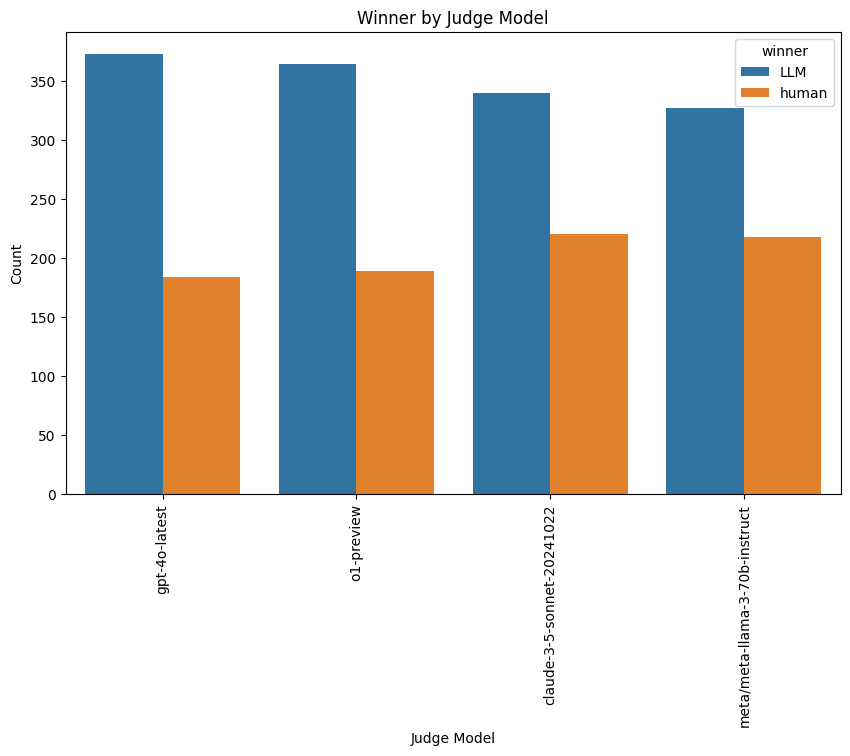

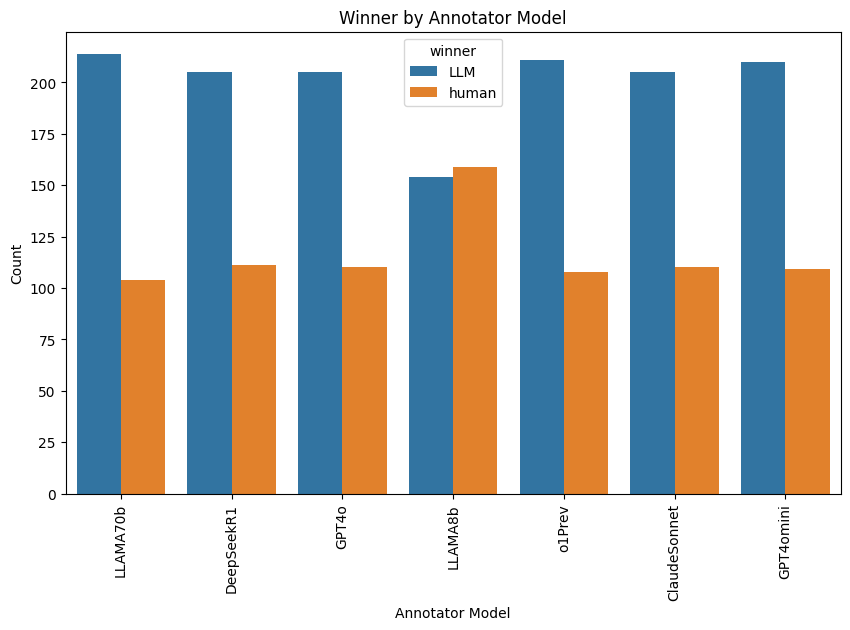

Winner counts (percentage):
winner
LLM      63.39
human    36.61
Name: proportion, dtype: float64
Winner by Prompt File (percentage):
prompt_file                           winner
pairwiseRanking_prompt.txt            LLM       62.61
                                      human     37.39
pairwiseRanking_prompt_detailled.txt  LLM       64.16
                                      human     35.84
Name: proportion, dtype: float64
Winner by Shot Mode (percentage):
ShotMode  winner
FewShot   LLM       64.29
          human     35.71
ZeroShot  LLM       62.49
          human     37.51
Name: proportion, dtype: float64
Winner by Judge Model (percentage):
model                           winner
claude-3-5-sonnet-20241022      LLM       60.71
                                human     39.29
gpt-4o-latest                   LLM       66.97
                                human     33.03
meta/meta-llama-3-70b-instruct  LLM       60.00
                                human     40.00
o1-preview           

In [33]:
run_preferenceRanking_analysis(df, statistical_deepdive=True)

Final answer counts:
final_answer
A    1226
B     989
Name: count, dtype: int64


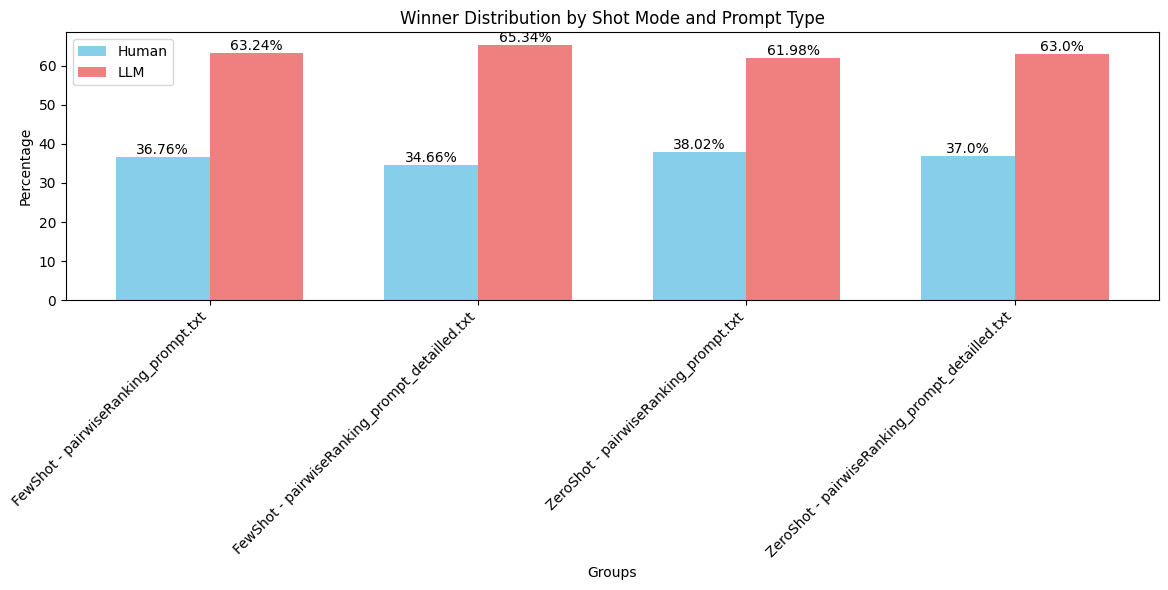


Contingency Table:
winner                                         LLM  human
ShotMode prompt_file                                     
FewShot  pairwiseRanking_prompt.txt            351    204
         pairwiseRanking_prompt_detailled.txt  360    191
ZeroShot pairwiseRanking_prompt.txt            344    211
         pairwiseRanking_prompt_detailled.txt  349    205

Chi-square test results:
Chi-square statistic: 1.42
p-value: 0.7020
Degrees of freedom: 3

There is no statistically significant difference between groups (p >= 0.05)


In [34]:
analyze_shot_mode_prompt_interaction(df)

### Large Dataset Analysis (n50, Taxonomy Validation Set)

In [35]:
# df1: GPT4o
df_gpt4o = pd.read_csv("../data/LLM-as-a-judge_outputs/results_TaxValSet50_AnnoByGPT4o_combined.csv")
df

# df2: ClaudeSonnet
df_claudesonnet = pd.read_csv("../data/LLM-as-a-judge_outputs/results_TaxValSet50_AnnoByClaudeSonnet_combined.csv")

# df3: LLAMA8bn
df_llama8bn = pd.read_csv("../data/LLM-as-a-judge_outputs/results_TaxValSet50_AnnoByLLAMA8bn_combined.csv")

df = pd.concat([df_gpt4o, df_claudesonnet, df_llama8bn], ignore_index=True)

# filter out all rows where final_answer not either "A" or "B"
df = df[df['final_answer'].isin(['A', 'B'])]

quick_inspection(df)

model
claude-3-5-sonnet-20241022        600
o1-preview                        595
gpt-4o-latest                     591
meta/meta-llama-3-70b-instruct    582
Name: count, dtype: int64
prompt_file
pairwiseRanking_prompt.txt              1191
pairwiseRanking_prompt_detailled.txt    1177
Name: count, dtype: int64
showed_first
human    1187
LLM      1181
Name: count, dtype: int64
AnnoModel
ClaudeSonnet    793
GPT-4o          790
LLAMA8bn        785
Name: count, dtype: int64


,example_id,final_answer,raw_response,showed_first,model,prompt_file,AnnoModel
0,3,B,To evaluate the annotations provided by Annota...,human,gpt-4o-latest,pairwiseRanking_prompt.txt,GPT-4o
1,0,B,To evaluate which annotator provided more accu...,human,gpt-4o-latest,pairwiseRanking_prompt.txt,GPT-4o
2,7,B,To determine which set of annotations better r...,human,gpt-4o-latest,pairwiseRanking_prompt.txt,GPT-4o
3,2,B,To evaluate which annotation set better reflec...,human,gpt-4o-latest,pairwiseRanking_prompt.txt,GPT-4o
4,4,A,Let's evaluate Annotator A and Annotator B bas...,human,gpt-4o-latest,pairwiseRanking_prompt.txt,GPT-4o


Final answer counts:
final_answer
A    1325
B    1043
Name: count, dtype: int64
Sample of processed data:
  showed_first final_answer winner
0        human            B    LLM
1        human            B    LLM
2        human            B    LLM
3        human            B    LLM
4        human            A  human


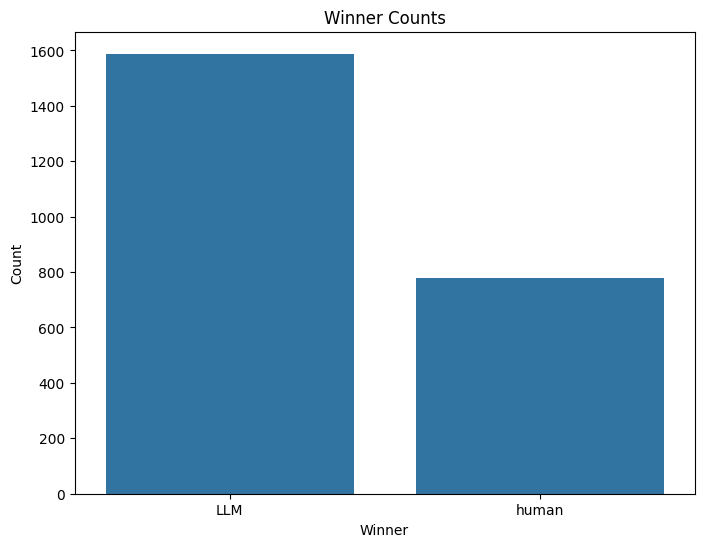

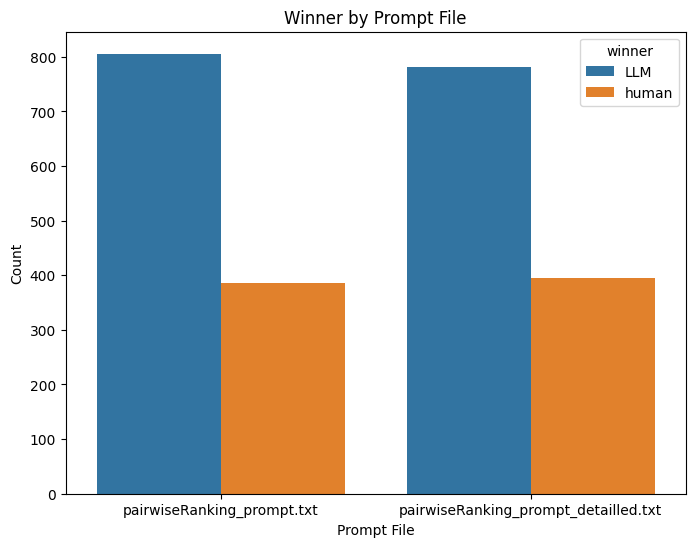

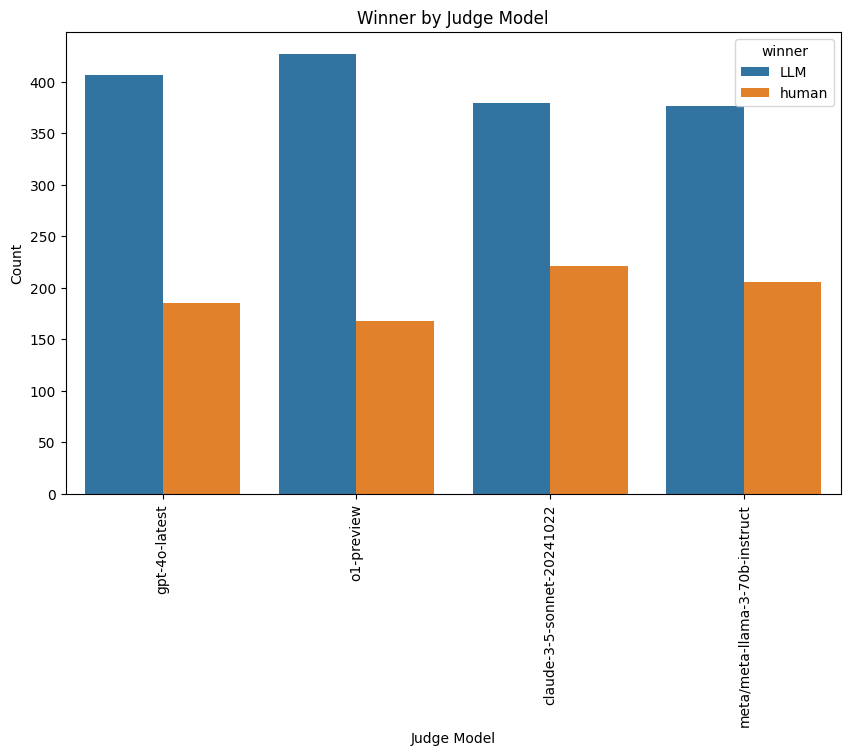

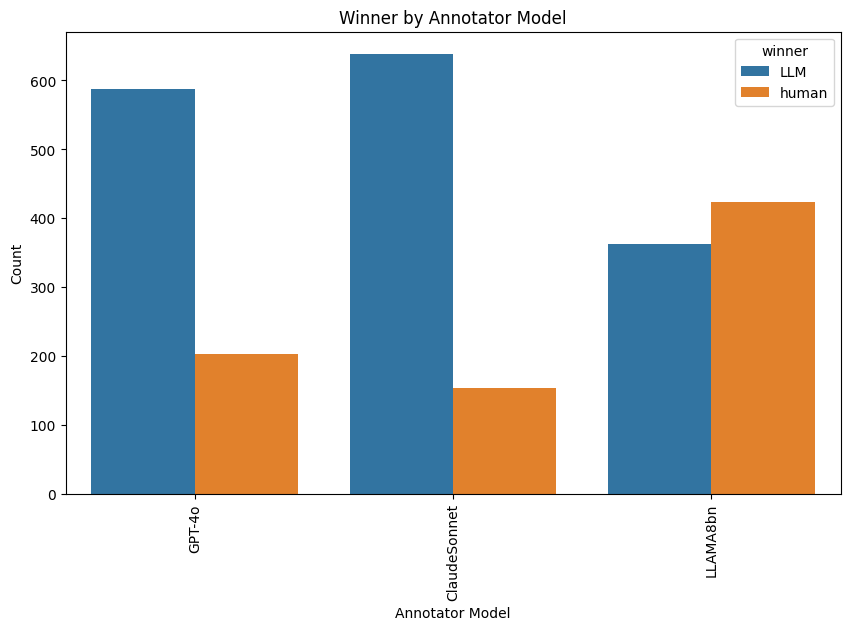

Winner counts (percentage):
winner
LLM      67.06
human    32.94
Name: proportion, dtype: float64
Winner by Prompt File (percentage):
prompt_file                           winner
pairwiseRanking_prompt.txt            LLM       67.67
                                      human     32.33
pairwiseRanking_prompt_detailled.txt  LLM       66.44
                                      human     33.56
Name: proportion, dtype: float64
Winner by Judge Model (percentage):
model                           winner
claude-3-5-sonnet-20241022      LLM       63.17
                                human     36.83
gpt-4o-latest                   LLM       68.70
                                human     31.30
meta/meta-llama-3-70b-instruct  LLM       64.60
                                human     35.40
o1-preview                      LLM       71.76
                                human     28.24
Name: proportion, dtype: float64
Winner by Annotator Model (percentage):
AnnoModel     winner
ClaudeSonnet  LLM  

In [36]:
run_preferenceRanking_analysis(df, statistical_deepdive=True)